In [18]:
import findspark 
findspark.init()

import pyspark 
from pyspark.sql import SparkSession 
spark = SparkSession.builder.getOrCreate()

In [31]:
from pyspark import SparkContext 
from pyspark.sql import Window,Row
from pyspark.sql.functions import * 
from pyspark.sql.types import * 
import matplotlib.pyplot as plt
import calendar

In [20]:
#SparkSession-entry point to programming Spark with Dataset and API 
spark = SparkSession \
        .builder \
        .appName("firstSpark")\
        .getOrCreate()

In [21]:
def load_dataframe(filename):
    df = spark.read.format('csv').options(header='True').load(filename)
    return df 

#creating dataframe 
df_matches = load_dataframe('./Data/Matches.csv')
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+



In [22]:
#rename columns
old_cols = df_matches.columns[-3:]
new_cols = ["HomeTeamGoals","AwayTeamGoals","FinalResult"]
old_new_cols = [*zip(old_cols, new_cols)]
for old_col, new_col in old_new_cols: 
    df_matches = df_matches.withColumnRenamed(old_col, new_col)
    
df_matches.limit(20).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A
5,6,D2,2009,2010-04-03,Union Berlin,Karlsruhe,1,1,D
6,7,D2,2009,2009-08-14,Paderborn,Karlsruhe,2,0,H
7,8,D2,2009,2010-03-08,Bielefeld,Karlsruhe,0,1,A
8,9,D2,2009,2009-09-26,Kaiserslautern,Karlsruhe,2,0,H
9,10,D2,2009,2009-11-21,Hansa Rostock,Karlsruhe,2,1,H


In [23]:
#1.Winners of D1 division in Germany Football Association (Bundesliga) in last decade 
df_matches = df_matches \
    .withColumn('HomeTeamWin', when(col('FinalResult') == 'H', 1).otherwise(0)) \
    .withColumn('AwayTeamWin', when(col('FinalResult') == 'A', 1).otherwise(0)) \
    .withColumn('GameTie', when(col('FinalResult') == 'D', 1).otherwise(0))


#bundesliga is a D1 division and we are interested in season <= 2010 and >= 2000
bundesliga = df_matches \
                    .filter((col('Season') >= 2000) & 
                            (col('Season') <= 2010) & 
                            (col('Div') == 'D1'))
#Aggregate home and away game results separately creating two dataframes: home and away 
# home team features
home = bundesliga.groupby('Season', 'HomeTeam') \
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
            sum('AwayTeamWin').alias('TotalHomeLoss'),
            sum('GameTie').alias('TotalHomeTie'),
            sum('HomeTeamGoals').alias('HomeScoredGoals'),
            sum('AwayTeamGoals').alias('HomeAgainstGoals')) \
       .withColumnRenamed('HomeTeam', 'Team')
 
#away game features 
away =  bundesliga.groupby('Season', 'AwayTeam') \
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
            sum('HomeTeamWin').alias('TotalAwayLoss'),
            sum('GameTie').alias('TotalAwayTie'),
            sum('AwayTeamGoals').alias('AwayScoredGoals'),
            sum('HomeTeamGoals').alias('AwayAgainstGoals'))  \
       .withColumnRenamed('AwayTeam', 'Team')

In [24]:
df_matches = df_matches \
    .withColumn('HomeTeamWin',when(col('FinalResult')=='H',1).otherwise(0))\
    .withColumn('AwayTeamWin',when(col('FinalResult')=='A',1).otherwise(0))\
    .withColumn('GameTie',when(col('FinalResult')=='D',1).otherwise(0))

#Filter D1 and 2000->2010
bundesliga = df_matches.filter((col('Season')>=2000) & (col('Season')<=2010) & (col('Div') == 'D1'))
bundesliga



DataFrame[Match_ID: string, Div: string, Season: string, Date: string, HomeTeam: string, AwayTeam: string, HomeTeamGoals: string, AwayTeamGoals: string, FinalResult: string, HomeTeamWin: int, AwayTeamWin: int, GameTie: int]

In [10]:
#season features 
window = ['Season']
window = Window.partitionBy(window).orderBy(col('WinPct').desc(),col('GoalDIfferentials').desc())
table = home.join(away,['Team','Season'],'inner')\
    .withColumn('GoalsScored',col('HomeScoredGoals')+col('AwayScoredGoals'))\
    .withColumn('GoalsAgainst',col('HomeAgainstGoals')+col('AwayAgainstGoals'))\
    .withColumn('GoalDifferentials',col('GoalsScored')-col('GoalsAgainst'))\
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('WinPct', round((100* col('Win')/(col('Win') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeTie', 'TotalAwayTie') \
    .withColumn('TeamPosition', rank().over(window))

table_df = table.filter(col('TeamPosition') == 1).orderBy(asc('Season')).toPandas()
table_df

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Bayern Munich,2000,62.0,37.0,25.0,19,9,6,55.88,1
1,Leverkusen,2001,77.0,38.0,39.0,21,7,6,61.76,1
2,Bayern Munich,2002,70.0,25.0,45.0,23,5,6,67.65,1
3,Werder Bremen,2003,79.0,38.0,41.0,22,4,8,64.71,1
4,Bayern Munich,2004,75.0,33.0,42.0,24,5,5,70.59,1
5,Bayern Munich,2005,67.0,32.0,35.0,22,3,9,64.71,1
6,Stuttgart,2006,61.0,37.0,24.0,21,6,7,61.76,1
7,Bayern Munich,2007,68.0,21.0,47.0,22,2,10,64.71,1
8,Wolfsburg,2008,80.0,41.0,39.0,21,7,6,61.76,1
9,Bayern Munich,2009,72.0,31.0,41.0,20,4,10,58.82,1


In [25]:
#Window function
#window = Window.partitionBy('Team').orderby('WinPct')
table.groupby('Team').agg(count('Team').alias("TotalChampionships"),
                          avg('WinPct').alias('AvgWinPct'),
                          avg('GoalDifferentials').alias('AvgGD'),
                          avg('Win').alias('AvgWin'),
                          avg('Loss').alias('AvgLoss'),
                          avg('Tie').alias('AvgTie')) \
    .orderBy(desc("TotalChampionships")).toPandas().round(1)

,Team,TotalChampionships,AvgWinPct,AvgGD,AvgWin,AvgLoss,AvgTie
0,Schalke 04,11,48.1,14.3,16.4,9.2,8.5
1,Werder Bremen,11,50.3,20.7,17.1,9.7,7.2
2,Leverkusen,11,47.3,17.8,16.1,10.0,7.9
3,Hamburg,11,41.2,5.2,14.0,10.9,9.1
4,Wolfsburg,11,37.4,3.2,12.7,13.0,8.3
5,Stuttgart,11,44.4,9.6,15.1,10.1,8.8
6,Bayern Munich,11,60.7,35.5,20.6,5.8,7.5
7,Dortmund,11,45.5,14.2,15.5,8.8,9.7
8,Hertha,10,40.0,2.8,13.6,12.1,8.3
9,Hannover,9,34.0,-9.0,11.6,13.9,8.6


In [27]:
df_teams = load_dataframe('./Data/Teams.csv')
df_teams.limit(5).toPandas()

,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2017,Bayern Munich,27,26,15,597950000,22150000,75000
1,2017,Dortmund,33,25,18,416730000,12630000,81359
2,2017,Leverkusen,31,24,15,222600000,7180000,30210
3,2017,RB Leipzig,30,23,15,180130000,6000000,42959
4,2017,Schalke 04,29,24,17,179550000,6190000,62271


In [28]:
# lets check for 2000s
relegated = table.filter((col('TeamPosition') == 16) | 
             (col('TeamPosition') == 17) |
             (col('TeamPosition') == 18)).orderBy(asc('Season')) 
relegated.filter(col('Season') == 2000).toPandas()

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Stuttgart,2000,42.0,49.0,-7.0,9,14,11,26.47,16
1,Unterhaching,2000,35.0,59.0,-24.0,8,15,11,23.53,17
2,Bochum,2000,30.0,67.0,-37.0,7,21,6,20.59,18


In [29]:
df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult,HomeTeamWin,AwayTeamWin,GameTie
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H,1,0,0
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A,0,1,0
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D,0,0,1
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H,1,0,0
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A,0,1,0


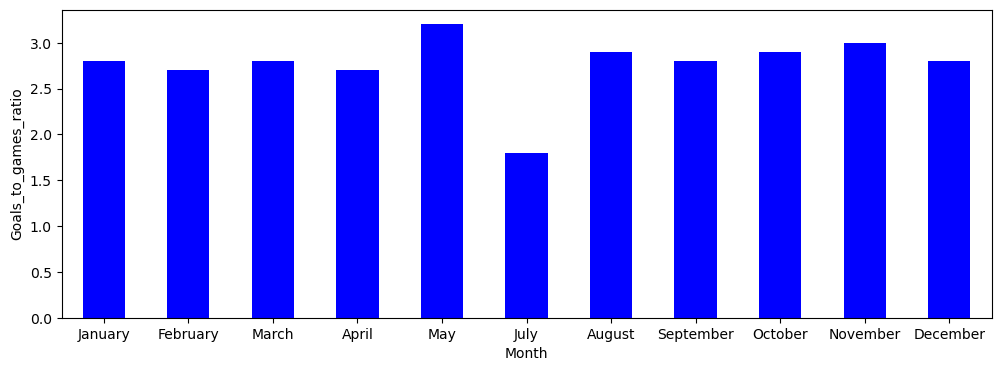

In [35]:
oktoberfest = df_matches \
                .filter(col('Div') == 'D1') \
                .filter((col('Season') >= 2000) &(col('Season') <= 2010)) \
                .withColumn('Month', month(col('Date'))) \
                .groupby('Month') \
                .agg(sum(col('HomeTeamGoals') + col('AwayTeamGoals')).alias('Goals'),
                     sum('GameTie').alias('GameTie'),
                     count(col('FinalResult')).alias('Total')) \
                .withColumn('Goals_to_games_ratio', round(col('Goals')/col('Total'), 1)) \
                .withColumn('GameTie_to_games_ratio', round(col('GameTie')/col('Total'), 1))

oktoberfest_df = oktoberfest.toPandas()

oktoberfest_df = oktoberfest_df.sort_values('Month')
oktoberfest_df['Month'] = [calendar.month_name[val] for val in oktoberfest_df.Month.tolist()]
oktoberfest_df.set_index('Month', drop=True, inplace=True)
oktoberfest_df['Goals_to_games_ratio'].plot.bar(rot=0, color='blue', figsize=(12, 4))
plt.ylabel('Goals_to_games_ratio')
plt.show()

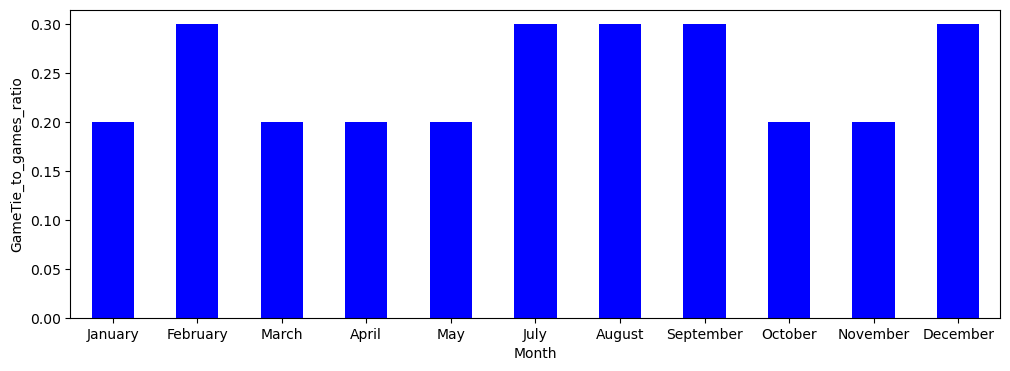

In [37]:
oktoberfest_df['GameTie_to_games_ratio'].plot.bar(rot=0, color='blue', figsize=(12, 4))
plt.ylabel('GameTie_to_games_ratio')
plt.show()